# AutoEncoder_RootMeanSquaredError_Super Resolution

In [1]:
import numpy as np
import pandas as pd 
import os
import glob
import shutil
import matplotlib.pyplot as plt


## Cria a base de dados a partir de https://www.kaggle.com/datasets/akhileshdkapse/super-image-resolution



In [2]:
inp_base_dir = 'dataset2'
dirnames = ['LR', 'HR']
out_base_dir = 'out'

In [3]:
for dirname in dirnames:
    img_path = os.path.join(inp_base_dir, dirname)
    images = glob.glob(img_path + '/*.png')
    print("{}: {} Images".format(dirname, len(images)))
    num_train = int(round(len(images)*0.8))
    train, val = images[:num_train], images[num_train:]

    for t in train:
        if not os.path.exists(os.path.join(out_base_dir, 'train', dirname)):
            os.makedirs(os.path.join(out_base_dir, 'train', dirname))
        shutil.copy(t, os.path.join(out_base_dir, 'train', dirname))

    for v in val:
        if not os.path.exists(os.path.join(out_base_dir, 'val', dirname)):
            os.makedirs(os.path.join(out_base_dir, 'val', dirname))
        shutil.copy(v, os.path.join(out_base_dir, 'val', dirname))

LR: 100 Images
HR: 100 Images


In [4]:
train_dir = os.path.join(out_base_dir,'train')
val_dir  = os.path.join(out_base_dir, 'val')

In [5]:
import tensorflow as tf

IMG_SHAPE = 256

In [6]:
def process_and_scale_train(filepath):
    img_input = tf.io.read_file(filepath)
    img_input = tf.image.decode_jpeg(img_input)
    img_input = tf.image.resize(img_input,[IMG_SHAPE,IMG_SHAPE])
    
    img_output = tf.io.read_file(train_dir + tf.strings.join(["/HR/", tf.strings.split(filepath, os.sep)[-1]]))
    img_output = tf.image.decode_jpeg(img_output)
    img_output = tf.image.resize(img_output,[IMG_SHAPE,IMG_SHAPE])
    
    return img_input/255., img_output/255.

In [7]:
def process_and_scale_val(filepath):
    img_input = tf.io.read_file(filepath)
    img_input = tf.image.decode_jpeg(img_input)
    img_input = tf.image.resize(img_input,[IMG_SHAPE,IMG_SHAPE])
    
    img_output = tf.io.read_file(val_dir + tf.strings.join(["/HR/", tf.strings.split(filepath, os.sep)[-1]]))
    img_output = tf.image.decode_jpeg(img_output)
    img_output = tf.image.resize(img_output,[IMG_SHAPE,IMG_SHAPE])
    
    return img_input/255., img_output/255.

In [8]:
train_ds_lr_files = tf.data.Dataset.list_files(train_dir + "/LR/*", shuffle = False)
val_ds_lr_files = tf.data.Dataset.list_files(val_dir + "/LR/*", shuffle = False)

In [9]:
train_dataset_lr = train_ds_lr_files.shuffle(len(train_ds_lr_files)).map(process_and_scale_train).batch(8).prefetch(tf.data.AUTOTUNE)
val_dataset_lr = val_ds_lr_files.map(process_and_scale_val).batch(8).prefetch(tf.data.AUTOTUNE)

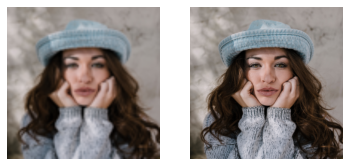

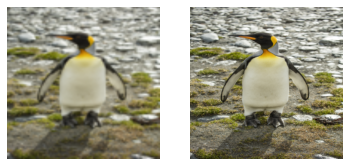

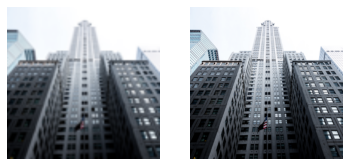

In [10]:
for train_lr, train_hr in train_dataset_lr.take(3):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(train_lr[0].numpy())
    ax[0].axis("off")
    ax[1].imshow(train_hr[0].numpy())
    ax[1].axis("off")

## Cria o modelo AutoEncoder

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Conv2DTranspose, Lambda, Reshape, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model

In [12]:
input_img = tf.keras.layers.Input(shape=(IMG_SHAPE, IMG_SHAPE, 3))

l1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(input_img)
l2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l1)
l3 = tf.keras.layers.MaxPool2D(padding='same')(l2)

l4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l3)
l5 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l4)
l6 = tf.keras.layers.MaxPool2D(padding='same')(l5)

l7 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l6)

l8 = tf.keras.layers.Conv2DTranspose(64, 3, 
                                     padding='same', 
                                     activation='relu',
                                     strides=(2,2))(l7)
l9 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l8)
l10 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l9)

l11 = tf.keras.layers.add([l10, l5])

l12 = tf.keras.layers.Conv2DTranspose(64, 3, 
                                     padding='same', 
                                     activation='relu',
                                     strides=(2,2))(l11)
l13 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l12)
l14 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l13)

l15 = tf.keras.layers.add([l14, l2])

decoded_image = tf.keras.layers.Conv2D(3, (3, 3), padding='same', kernel_initializer='he_uniform', activation='sigmoid', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l15)

autoencoder = tf.keras.models.Model(inputs=(input_img), outputs=decoded_image)

autoencoder.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), #optimizer='adam', #optimizer='adadelta',
                    loss='mean_squared_error', # mean_absolute_error
                    metrics = [tf.keras.metrics.RootMeanSquaredError(name = 'rmse')]) # tf.keras.metrics.RootMeanSquaredError

In [23]:
#autoencoder.summary()

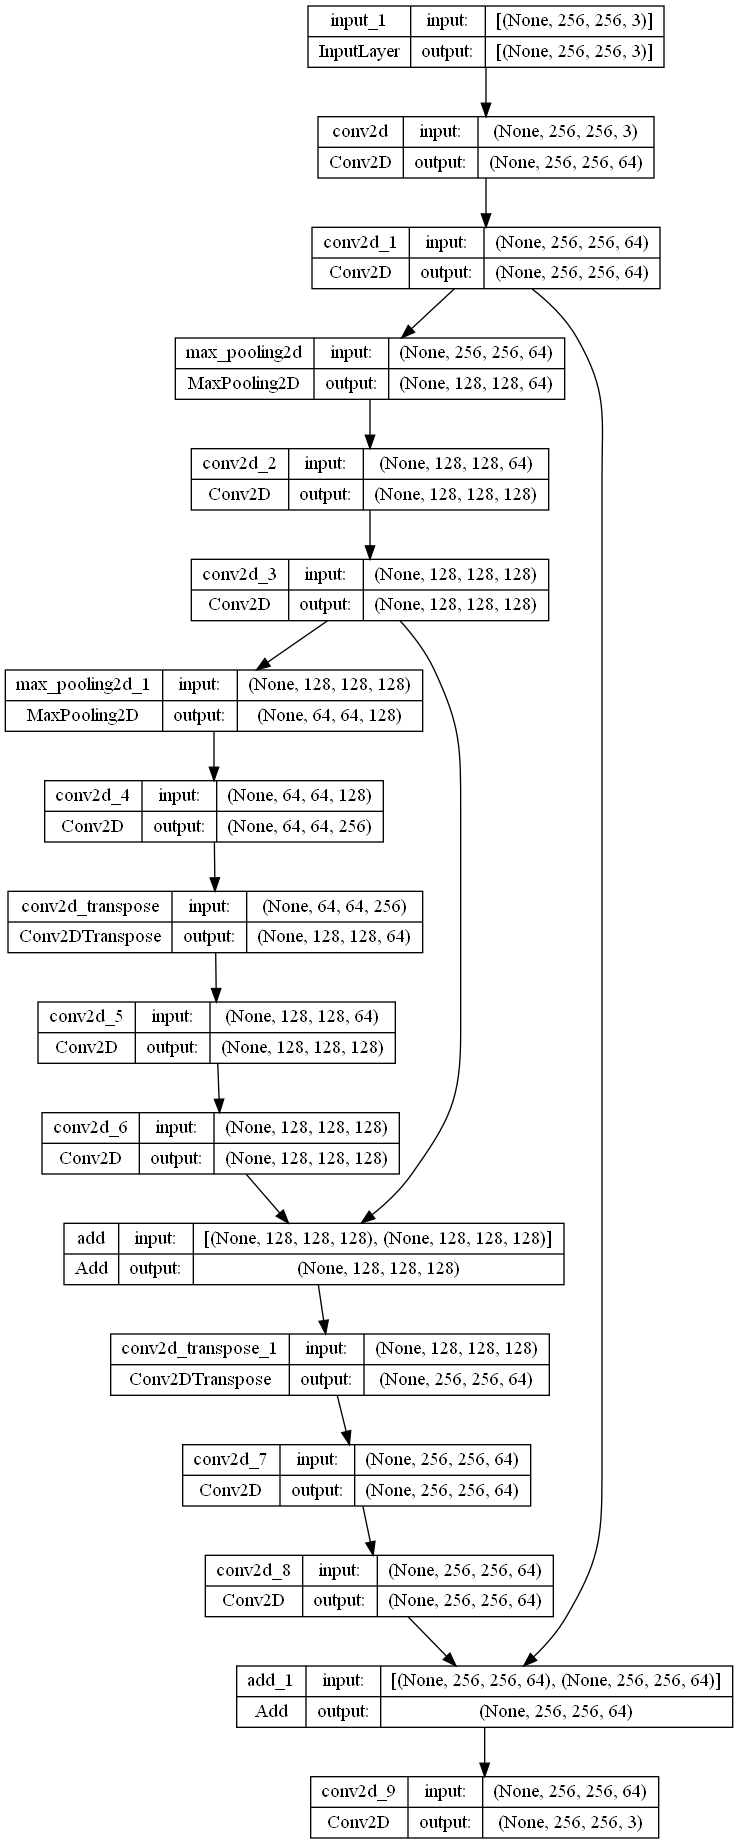

In [14]:
plot_model(autoencoder, show_shapes=True)

## Treiar o modelo

In [ ]:
# Early Stopping do trinamento
early_stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    min_delta=0.0001, 
    patience=7
)

model_ckpt = keras.callbacks.ModelCheckpoint(
    filepath='callbacks/melhor_modelo_callbacks.hdf5', 
    monitor='val_loss', 
    save_best_only=True
)

callbacks = [early_stop, model_ckpt]

history = autoencoder.fit(train_dataset_lr,
                          validation_data = val_dataset_lr,
                          epochs = 400, callbacks=callbacks) 

In [16]:
def plot_model(model_name_history):
    # Plot loss per iteration
    fig, ax = plt.subplots(1, 2,figsize=(15,5))

    ax[0].plot(model_name_history.history['loss'], label='loss')
    ax[0].plot(model_name_history.history['val_loss'], label='val_loss')
    ax[0].legend()
    
    # Plot rmse per iteration
    ax[1].plot(model_name_history.history['rmse'], label='rmse')
    ax[1].plot(model_name_history.history['val_rmse'], label='val_rmse')
    ax[1].legend()

In [ ]:
plot_model(history)

(-0.5, 255.5, 255.5, -0.5)

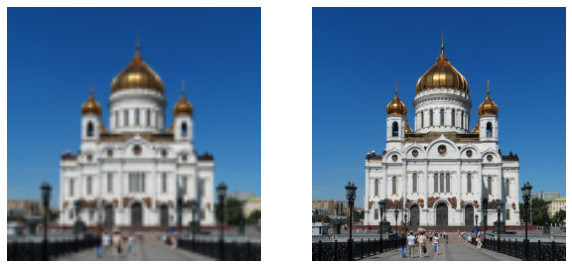

In [21]:
for img_input, img_output in val_dataset_lr.take(1):
    fig, ax = plt.subplots(1,2, figsize = (10,10))
    
ax[0].imshow(img_input.numpy()[0])
ax[0].axis("off")
ax[1].imshow(img_output.numpy()[0])
ax[1].axis("off")

1/1 [==============================] - 0s 73ms/step


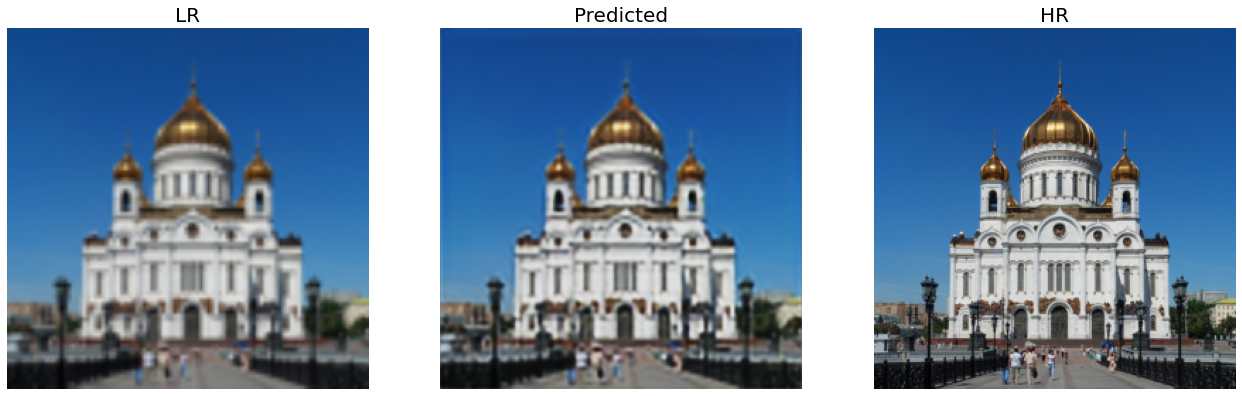

In [22]:
pred2 = autoencoder.predict(val_dataset_lr.take(1))

plt.figure(figsize=(22,22))
plt.subplot(1,3,1)
plt.title('LR', fontsize=20)
plt.axis(False)
plt.imshow(img_input.numpy()[0])
plt.subplot(1,3,2)
plt.title('Predicted', fontsize=20)
plt.axis(False)
plt.imshow(pred2[0])
plt.subplot(1,3,3)
plt.title('HR', fontsize=20)
plt.axis(False)
plt.imshow(img_output.numpy()[0])